# 🏀 Análise de Desempenho dos Times Visitantes por Cidade

O objetivo desta análise é identificar quais cidades são **mais favoráveis para os times visitantes** na NBA. Avaliaremos onde os visitantes:

- Vencem mais partidas
- Marcam mais pontos
- Têm melhor desempenho geral
- Possuem histórico de vitórias consistente AAAAAAAAA acho que tem que reescrever isso pq é só os pontos em Minessota

Essa visão pode oferecer insights sobre vantagem de mando, impacto da torcida, ou até mesmo desempenho inconsistente dos times da casa.


In [6]:
# Importando bibliotecas válidas para a análise
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve

In [7]:
# Carregando csvs utilizados para  a análise
game = pd.read_csv('csv/game.csv')
gameSummary = pd.read_csv('csv/game_summary.csv')
team = pd.read_csv('csv/team.csv')

# Analizando quais colunas estão disponíveis para utilizarmos na análise
game.head(), gameSummary.head(), team.head()


(   season_id  team_id_home team_abbreviation_home           team_name_home  \
 0      21946    1610610035                    HUS          Toronto Huskies   
 1      21946    1610610034                    BOM        St. Louis Bombers   
 2      21946    1610610032                    PRO  Providence Steamrollers   
 3      21946    1610610025                    CHS            Chicago Stags   
 4      21946    1610610028                    DEF          Detroit Falcons   
 
     game_id            game_date matchup_home wl_home  min  fgm_home  ...  \
 0  24600001  1946-11-01 00:00:00  HUS vs. NYK       L    0      25.0  ...   
 1  24600003  1946-11-02 00:00:00  BOM vs. PIT       W    0      20.0  ...   
 2  24600002  1946-11-02 00:00:00  PRO vs. BOS       W    0      21.0  ...   
 3  24600004  1946-11-02 00:00:00  CHS vs. NYK       W    0      21.0  ...   
 4  24600005  1946-11-02 00:00:00  DEF vs. WAS       L    0      10.0  ...   
 
    reb_away  ast_away  stl_away  blk_away  tov_away  

In [8]:
# Use apenas colunas necessárias do DataFrame 'team'
teamHome = team[['id', 'city']].rename(columns={'id': 'team_id_home', 'city': 'city_home'})
teamAway = team[['id', 'city']].rename(columns={'id': 'team_id_away', 'city': 'city_away'})

# Merge com as cidades dos times da casa
game = game.merge(teamHome, on='team_id_home', how='left')

# Merge com as cidades dos times visitantes
game = game.merge(teamAway, on='team_id_away', how='left')


## Taxa de Vitórias dos Visitantes por Cidade

Nesta etapa, calculamos a **proporção de vitórias dos times visitantes** em cada cidade. 

Uma vitória do visitante ocorre quando o time da casa perde. Agrupamos os dados por `city_home` e contabilizamos:

- Número total de partidas na cidade
- Número de vitórias dos visitantes
- Taxa de vitória dos visitantes (vitórias / total de jogos)

Também filtramos para considerar **somente cidades com pelo menos 20 jogos**, para evitar distorções por amostras pequenas.


In [9]:
# Definindo a vitória de um visitante se o wl_home = L (Time da casa perdeu)
game['visitor_win'] = game['wl_home'] == 'L'

# Agrupando por cidade do time da casa e calculando o total de jogos em que o time visitante ganha
visitorsWinByCity = game.groupby('city_home').agg(
    visitor_wins=('visitor_win', 'sum'),           # Quantidade total de vitórias visitantes
    games_played=('visitor_win', 'count')          # Quantidade total de jogos jogados naquela cidade
).reset_index()

# Calculando taxa de vitória de vitória de visitantes
visitorsWinByCity['winRate'] = (
    visitorsWinByCity['visitor_wins'] / visitorsWinByCity['games_played']
)

# Filtrando cidades com muito poucos jogos (Menos que vinte)
visitorsWinByCity = visitorsWinByCity[visitorsWinByCity['games_played'] >= 20]

visitorsWinByCity = visitorsWinByCity.sort_values('winRate', ascending=False)
visitorsWinByCity.head(10)

,city_home,visitor_wins,games_played,winRate
16,Minnesota,708,1390,0.509353
13,Memphis,553,1173,0.471441
3,Charlotte,632,1345,0.469888
2,Brooklyn,900,1923,0.468019
17,New Orleans,382,870,0.439080
26,Toronto,512,1187,0.431340
28,Washington,1034,2404,0.430116
20,Orlando,599,1427,0.419762
6,Dallas,748,1833,0.408074
5,Cleveland,873,2146,0.406803


## Cidades Onde os Visitantes Mais Vencem

O gráfico a seguir mostra as **10 cidades com maior taxa de vitórias para visitantes**. Quanto maior a barra, maior a proporção de vezes que os visitantes ganharam naquela cidade.

Essa visualização ajuda a identificar os locais onde a vantagem de mando é mais fraca.


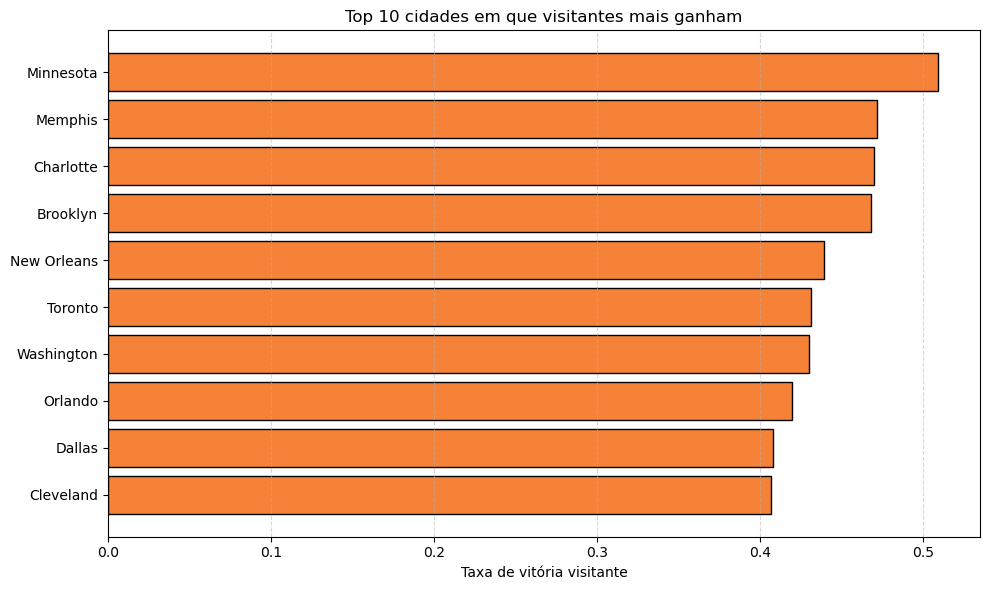

In [18]:
# Plotando um gráfico de barras para que seja possível analisar quais as 10 cidades em que visitantes mais ganham
topWinCities = visitorsWinByCity.sort_values('winRate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(topWinCities['city_home'], topWinCities['winRate'], color='#f68238', edgecolor='black')
plt.xlabel('Taxa de vitória visitante')
plt.title('Top 10 cidades em que visitantes mais ganham')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



## Cidades Onde Visitantes Marcam Mais Pontos

Além das vitórias, também analisamos **a média de pontos marcados por visitantes em cada cidade**.

Essa métrica complementa a taxa de vitória, indicando onde os visitantes têm melhor desempenho ofensivo — mesmo que nem sempre vençam.


In [11]:
# Calculando quantos pontos os visitantes fazem por cidade
visitorPoints = game.groupby('city_home').agg(
    avg_pts_away=('pts_away', 'mean'), # Calculando a média de pontos visitantes
    std_pts_away=('pts_away', 'std'),  # Calculando desvio padrão
    num_games=('pts_away', 'count')    # Calculando quantidade de jogos
).reset_index()

visitorPoints.sort_values('avg_pts_away', ascending=False).head()


,city_home,avg_pts_away,std_pts_away,num_games
7,Denver,106.114242,13.876211,1952
22,Phoenix,104.619618,12.920219,2253
28,Washington,103.658070,12.682179,2404
9,Golden State,103.382783,15.225829,2939
24,Sacramento,102.881308,14.917838,2814


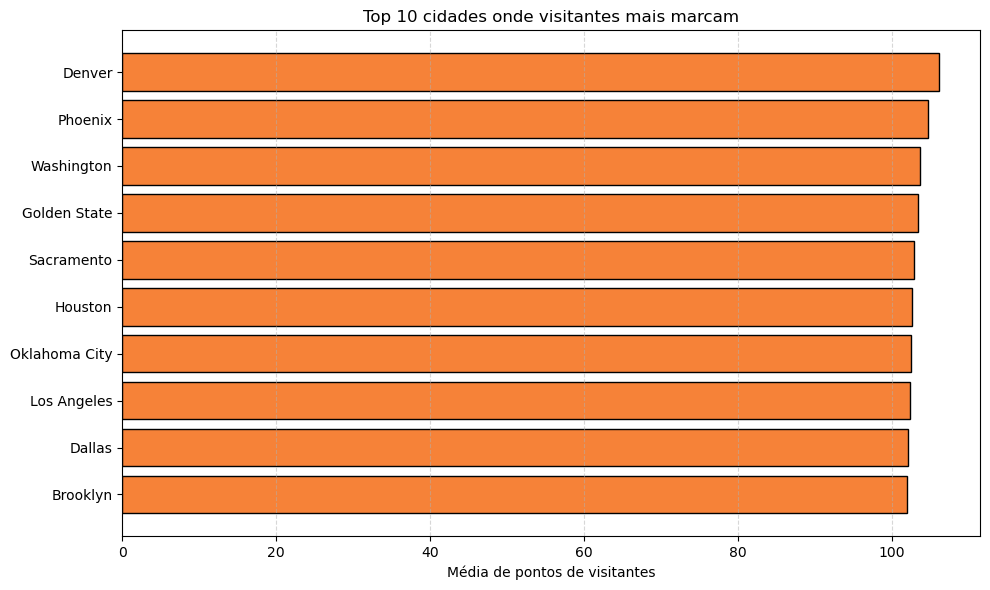

In [19]:
# Plotando gráfico de barras que facilita a vizualição de quantos pontos os visitantes marcam nos top 10 cidades
topPtsCities = visitorPoints.sort_values('avg_pts_away', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(topPtsCities['city_home'], topPtsCities['avg_pts_away'], color='#f68238', edgecolor='black')
plt.xlabel('Média de pontos de visitantes')
plt.title('Top 10 cidades onde visitantes mais marcam')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Score Composto de Favorabilidade para Visitantes

Combinamos múltiplos indicadores para gerar um **score composto** de "cidades favoráveis para visitantes", levando em conta:

- Taxa de vitórias dos visitantes
- Média de pontos marcados
- Plus/minus médio dos visitantes

Esse índice balanceado permite classificar as cidades de forma mais robusta, considerando não apenas vitórias mas também qualidade do desempenho.


In [13]:
# Acrescentando algumas estatísticas de visitantes para agregar no compilado final
visitorsStats = game.groupby('city_home').agg(
    avg_ast_away=('ast_away', 'mean'),
    avg_reb_away=('reb_away', 'mean'),
    avg_stl_away=('stl_away', 'mean'),
    avg_blk_away=('blk_away', 'mean'),
    avg_plus_minus=('plus_minus_away', 'mean')
).reset_index()

visitorsStats.head()


,city_home,avg_ast_away,avg_reb_away,avg_stl_away,avg_blk_away,avg_plus_minus
0,Atlanta,22.194175,42.670562,7.882171,4.326193,-3.730769
1,Boston,21.868393,41.685820,7.963218,4.486857,-6.051857
2,Brooklyn,21.020255,42.413534,8.350877,5.174157,-0.953198
3,Charlotte,22.581413,42.599257,6.975465,5.092937,-0.775465
4,Chicago,22.388920,41.570321,7.732069,4.852837,-3.424557


In [14]:
# Agrupando todas as métricas
favCitiesStats = visitorsWinByCity.merge(visitorPoints, on='city_home')
favCitiesStats = favCitiesStats.merge(visitorsStats, on='city_home')

# Cálculo do "Composite Score" (pontuação composta) — os valores foram definidos pelo grupo! 
favCitiesStats['composite_score'] = (
    favCitiesStats['winRate'] * 0.4 +  # 40% do peso vem da taxa de vitórias dos visitantes na cidade

    # 30% do peso vem da média de pontos dos visitantes, normalizada pela maior média registrada
    favCitiesStats['avg_pts_away'] / favCitiesStats['avg_pts_away'].max() * 0.3 +

    # 30% do peso vem do plus-minus médio dos visitantes, também normalizado
    favCitiesStats['avg_plus_minus'] / favCitiesStats['avg_plus_minus'].max() * 0.3
)

favCitiesStats.sort_values('composite_score', ascending=False).head(10)


,city_home,visitor_wins,games_played,winRate,avg_pts_away,std_pts_away,num_games,avg_ast_away,avg_reb_away,avg_stl_away,avg_blk_away,avg_plus_minus,composite_score
28,San Antonio,592,2040,0.290196,99.958333,14.844981,2040,21.224793,41.255647,7.853428,4.669817,-6.714706,9.489689
26,Utah,636,2013,0.315946,99.472429,13.025432,2013,19.845110,40.315045,7.865408,4.967762,-6.159463,8.746875
27,Boston,923,3124,0.295455,100.226633,14.304470,3124,21.868393,41.685820,7.963218,4.486857,-6.051857,8.595122
25,Portland,723,2145,0.337063,101.713287,13.399583,2145,22.197167,40.497450,7.675841,4.206833,-5.142657,7.385007
24,Phoenix,772,2253,0.342654,104.619618,12.920219,2253,21.968379,42.429458,8.037172,4.520390,-5.118509,7.362765
23,Oklahoma City,812,2292,0.354276,102.489092,13.283675,2292,21.662514,40.798305,7.884896,4.476596,-4.681501,6.769727
18,Milwaukee,828,2253,0.367510,101.675100,12.370182,2253,22.965051,41.820180,7.711315,4.299514,-4.569463,6.621032
21,Denver,705,1952,0.361168,106.114242,13.876211,1952,23.016715,43.129534,7.663970,5.514605,-4.240779,6.186041
15,Indiana,736,1946,0.378212,100.181912,13.794891,1946,20.851173,42.575844,7.845114,4.855917,-4.001028,5.851489
16,Houston,868,2299,0.377555,102.575468,13.792249,2299,22.237212,42.553682,8.324683,4.624925,-3.923010,5.752366


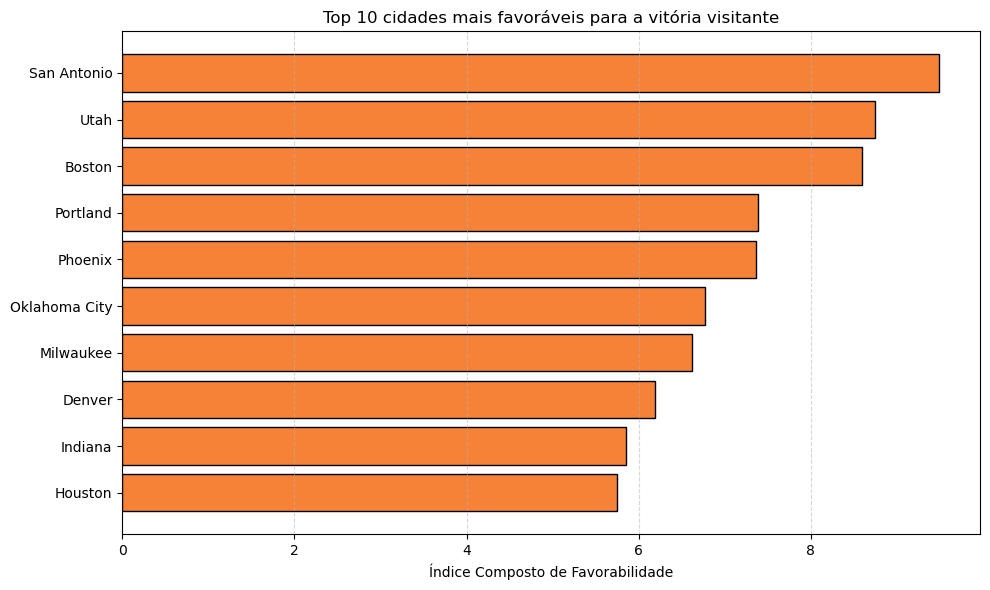

In [20]:
# Plotando quais as 10 cidades mais favoráveis para os visitantes conforme as variáveis observadas pelo grupo
topCompositieCities = favCitiesStats.sort_values('composite_score', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(topCompositieCities['city_home'], topCompositieCities['composite_score'], color='#f68238', edgecolor='black')
plt.xlabel('Índice Composto de Favorabilidade')
plt.title('Top 10 cidades mais favoráveis para a vitória visitante')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Análise Estatística: Pontuação dos Visitantes por Cidade (ANOVA)
Nesta etapa, realizamos uma análise de variância para investigar se times visitantes pontuam de forma significativamente diferente dependendo da cidade onde jogam.

Interpretando o p-valor:

Se p < 0.05, há diferença estatisticamente significativa entre as cidades — ou seja, os visitantes pontuam de forma diferente dependendo de onde jogam.

Se p ≥ 0.05, as diferenças observadas podem ser atribuídas ao acaso.

In [16]:
from scipy.stats import f_oneway

# Converter datas e filtrar últimas 10 temporadas
game['game_date'] = pd.to_datetime(game['game_date'])
last_10 = game[game['game_date'] >= '2013-07-01']

# Remover entradas sem cidade ou pontos de visitante
last_10_clean = last_10.dropna(subset=['city_home', 'pts_away'])

# Agrupar os pontos dos visitantes por cidade
visitor_points_by_city = last_10_clean.groupby('city_home')['pts_away'].apply(list)

# Realizar teste F
f_stat, p_val = f_oneway(*visitor_points_by_city)

# Resultados
print("Pontos dos Visitantes por Cidade")
print("F-value:", f_stat)
print("p-value:", p_val)

# Interpretação
if p_val < 0.05:
    print("Resultado: Há diferença estatisticamente significativa entre as cidades.")
else:
    print("Resultado: Não há diferença estatisticamente significativa entre as cidades.")


Pontos dos Visitantes por Cidade
F-value: 10.221731224372695
p-value: 4.554920032901828e-44
Resultado: Há diferença estatisticamente significativa entre as cidades.


## Distribuição de Pontos dos Visitantes na Cidade Mais Favorável

Este histograma mostra a **distribuição de pontos marcados pelos times visitantes na cidade onde eles mais vencem**.

É uma análise mais granular, que revela se os visitantes consistentemente pontuam alto ou se há muita variação nos resultados.


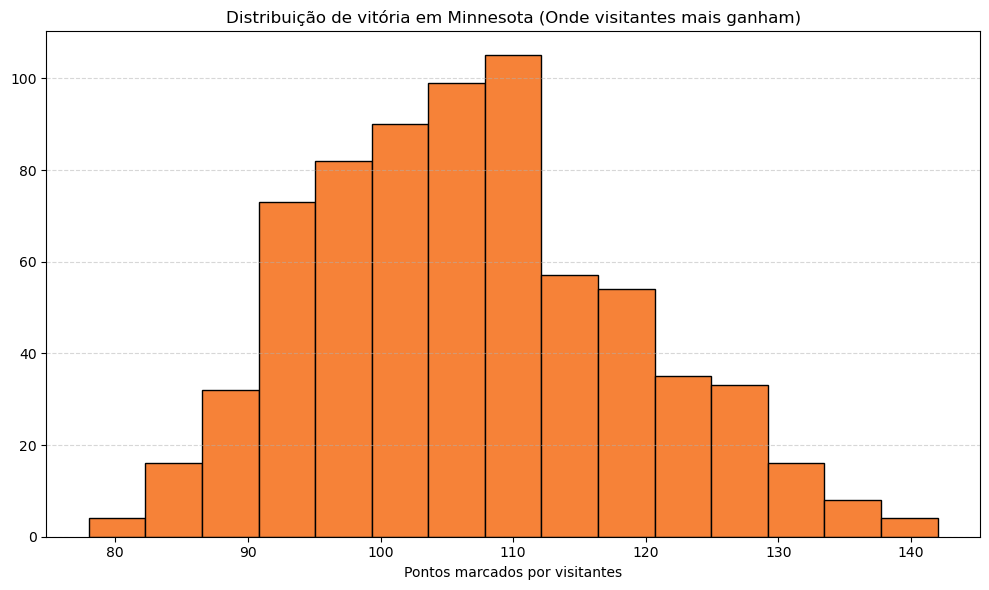

In [21]:
# Selecionamos a cidade onde os visitantes mais ganham
topCity = visitorsWinByCity.iloc[0]['city_home']

# Selecionamos apenas jogos com vitórias de visitantes
visitorsWinsInTopCities = game[(game['city_home'] == topCity) & (game['visitor_win'])]

plt.figure(figsize=(10, 6))
plt.hist(visitorsWinsInTopCities['pts_away'], bins=15, color='#f68238', edgecolor='black')
plt.xlabel('Pontos marcados por visitantes')
plt.title(f'Distribuição de vitória em {topCity} (Onde visitantes mais ganham)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
